## Detección de raza de perros

http://vision.stanford.edu/aditya86/ImageNetDogs/

## Ejemplo  de uso

Vamos a ver como podemos utilizar el modelo `Faster R-CNN` disponible en `torchvision` para generar detecciones. En primer lugar vamos a utilizar el mismo dataset que hemos usado en los vídeos anteriores, el dataset `VOC` (el modelo `Faster R-CNN` de `torchvision` está entrenado en el dataset `COCO`)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# mount it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

path = "/content/data"
os.mkdir(path)

In [4]:
import shutil
shutil.copy("/content/drive/MyDrive/datasets/stanford_dogs/annotation.tar", "/content/data/anotation.tar")
shutil.copy("/content/drive/MyDrive/datasets/stanford_dogs/images.tar", "/content/data/images.tar")
shutil.copy("/content/drive/MyDrive/datasets/stanford_dogs/lists.tar", "/content/data/lists.tar")

shutil.unpack_archive("/content/drive/MyDrive/datasets/stanford_dogs/images.tar", "/content/data")
shutil.unpack_archive("/content/drive/MyDrive/datasets/stanford_dogs/annotation.tar", "/content/data")
shutil.unpack_archive("/content/drive/MyDrive/datasets/stanford_dogs/lists.tar", "/content/data")

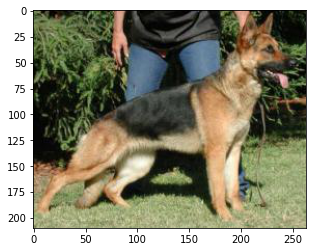

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('/content/data/Images/n02106662-German_shepherd/n02106662_11808.jpg')

imgplot = plt.imshow(img)

In [15]:
from PIL import Image
from os.path import join
import os
import scipy.io
import collections
import torch.utils.data as data
from torchvision.datasets.utils import download_url, list_dir, list_files
from xml.etree.ElementTree import Element as ET_Element
try:
    from defusedxml.ElementTree import parse as ET_parse
except ImportError:
    from xml.etree.ElementTree import parse as ET_parse


class BreedsDogs(data.Dataset):
    """`Stanford Dogs <http://vision.stanford.edu/aditya86/ImageNetDogs/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``omniglot-py`` exists.
        cropped (bool, optional): If true, the images will be cropped into the bounding box specified
            in the annotations
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset tar files from the internet and
            puts it in root directory. If the tar files are already downloaded, they are not
            downloaded again.
    """
    folder = 'data'
    download_url_prefix = 'http://vision.stanford.edu/aditya86/ImageNetDogs'

    def __init__(self,
                 root,
                 train=True,
                 transforms=None,
                 download=False):

        self.root = join(os.path.expanduser(root), self.folder)
        # print(f"directorio raiz: {self.root}")

        self.train = train
        self.transforms = transforms
        if download:
            self.download()

        self.split = self.load_split()
        # print("Anotaciones")
        # print(self.split)

        self.images_folder = join(self.root, 'Images')
        # print(f"directorio de imagenes: {self.images_folder}")
        self.annotations_folder = join(self.root, 'Annotation')
        # print(f"directorio de anotaciones: {self.annotations_folder}")

        self._breeds = list_dir(self.images_folder)
        # print("Tipos de perros:")
        # print(self._breeds)

        self._breed_images = [(annotation+'.jpg', idx) for annotation, idx in self.split]

        # print("Imagenes por raza:")
        # print(self._breed_images[:5])
        # self.classes = ["Chihuaha",
        #                 "Japanese Spaniel",
        #                 "Maltese Dog",
        #                 "Pekinese",
        #                 "Shih-Tzu",
        #                 "Blenheim Spaniel",
        #                 "Papillon",
        #                 "Toy Terrier",
        #                 "Rhodesian Ridgeback",
        #                 "Afghan Hound",
        #                 "Basset Hound",
        #                 "Beagle",
        #                 "Bloodhound",
        #                 "Bluetick",
        #                 "Black-and-tan Coonhound",
        #                 "Walker Hound",
        #                 "English Foxhound",
        #                 "Redbone",
        #                 "Borzoi",
        #                 "Irish Wolfhound",
        #                 "Italian Greyhound",
        #                 "Whippet",
        #                 "Ibizian Hound",
        #                 "Norwegian Elkhound",
        #                 "Otterhound",
        #                 "Saluki",
        #                 "Scottish Deerhound",
        #                 "Weimaraner",
        #                 "Staffordshire Bullterrier",
        #                 "American Staffordshire Terrier",
        #                 "Bedlington Terrier",
        #                 "Border Terrier",
        #                 "Kerry Blue Terrier",
        #                 "Irish Terrier",
        #                 "Norfolk Terrier",
        #                 "Norwich Terrier",
        #                 "Yorkshire Terrier",
        #                 "Wirehaired Fox Terrier",
        #                 "Lakeland Terrier",
        #                 "Sealyham Terrier",
        #                 "Airedale",
        #                 "Cairn",
        #                 "Australian Terrier",
        #                 "Dandi Dinmont",
        #                 "Boston Bull",
        #                 "Miniature Schnauzer",
        #                 "Giant Schnauzer",
        #                 "Standard Schnauzer",
        #                 "Scotch Terrier",
        #                 "Tibetan Terrier",
        #                 "Silky Terrier",
        #                 "Soft-coated Wheaten Terrier",
        #                 "West Highland White Terrier",
        #                 "Lhasa",
        #                 "Flat-coated Retriever",
        #                 "Curly-coater Retriever",
        #                 "Golden Retriever",
        #                 "Labrador Retriever",
        #                 "Chesapeake Bay Retriever",
        #                 "German Short-haired Pointer",
        #                 "Vizsla",
        #                 "English Setter",
        #                 "Irish Setter",
        #                 "Gordon Setter",
        #                 "Brittany",
        #                 "Clumber",
        #                 "English Springer Spaniel",
        #                 "Welsh Springer Spaniel",
        #                 "Cocker Spaniel",
        #                 "Sussex Spaniel",
        #                 "Irish Water Spaniel",
        #                 "Kuvasz",
        #                 "Schipperke",
        #                 "Groenendael",
        #                 "Malinois",
        #                 "Briard",
        #                 "Kelpie",
        #                 "Komondor",
        #                 "Old English Sheepdog",
        #                 "Shetland Sheepdog",
        #                 "Collie",
        #                 "Border Collie",
        #                 "Bouvier des Flandres",
        #                 "Rottweiler",
        #                 "German Shepard",
        #                 "Doberman",
        #                 "Miniature Pinscher",
        #                 "Greater Swiss Mountain Dog",
        #                 "Bernese Mountain Dog",
        #                 "Appenzeller",
        #                 "EntleBucher",
        #                 "Boxer",
        #                 "Bull Mastiff",
        #                 "Tibetan Mastiff",
        #                 "French Bulldog",
        #                 "Great Dane",
        #                 "Saint Bernard",
        #                 "Eskimo Dog",
        #                 "Malamute",
        #                 "Siberian Husky",
        #                 "Affenpinscher",
        #                 "Basenji",
        #                 "Pug",
        #                 "Leonberg",
        #                 "Newfoundland",
        #                 "Great Pyrenees",
        #                 "Samoyed",
        #                 "Pomeranian",
        #                 "Chow",
        #                 "Keeshond",
        #                 "Brabancon Griffon",
        #                 "Pembroke",
        #                 "Cardigan",
        #                 "Toy Poodle",
        #                 "Miniature Poodle",
        #                 "Standard Poodle",
        #                 "Mexican Hairless",
        #                 "Dingo",
        #                 "Dhole",
        #                 "African Hunting Dog"]

    def __len__(self):
        return len(self._breed_images)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target). target are the properties as annotations in image
        """
        image_name, target_class = self._breed_images[index]
        image_path = join(self.images_folder, image_name)
        image = Image.open(image_path).convert('RGB')
        target = self.parse_voc_xml(ET_parse(self.annotations_folder + '/' + self.split[index][0]).getroot())

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def parse_voc_xml(self, node: ET_Element):
        voc_dict = {}
        children = list(node)
        if children:
            def_dic = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict

    def download(self):
        import tarfile

        if os.path.exists(join(self.root, 'Images')) and os.path.exists(join(self.root, 'Annotation')):
            if len(os.listdir(join(self.root, 'Images'))) == len(os.listdir(join(self.root, 'Annotation'))) == 120:
                print('Files already downloaded and verified')
                return

        for filename in ['images', 'annotation', 'lists']:
            tar_filename = filename + '.tar'
            url = self.download_url_prefix + '/' + tar_filename
            download_url(url, self.root, tar_filename, None)
            print('Extracting downloaded file: ' + join(self.root, tar_filename))
            with tarfile.open(join(self.root, tar_filename), 'r') as tar_file:
                tar_file.extractall(self.root)
            os.remove(join(self.root, tar_filename))

    def load_split(self):
        if self.train:
            # print(f"directorio lista de entrenamiento: {self.root}")
            split = scipy.io.loadmat(join(self.root, 'train_list.mat'))['annotation_list']
            # print(split)
            labels = scipy.io.loadmat(join(self.root, 'train_list.mat'))['labels']
            # print(labels)
        else:
            split = scipy.io.loadmat(join(self.root, 'test_list.mat'))['annotation_list']
            labels = scipy.io.loadmat(join(self.root, 'test_list.mat'))['labels']

        split = [item[0][0] for item in split]
        labels = [item[0]-1 for item in labels]
        return list(zip(split, labels))

    def stats(self):
        counts = {}
        for index in range(len(self._breed_images)):
            image_name, target_class = self._breed_images[index]
            if target_class not in counts.keys():
                counts[target_class] = 1
            else:
                counts[target_class] += 1

        print(f"{ len(self._breed_images)} samples spanning { len(counts.keys()) }  classes (avg { float(len(self._breed_images)) / float(len(counts.keys())) } % per class")

        return counts


In [16]:
breeds_dogs_train_dataset = BreedsDogs('/content')
breeds_dogs_test_dataset = BreedsDogs('/content', train=False)
# classes = breeds_dogs_train_dataset.classes

print(breeds_dogs_train_dataset[0])

(<PIL.Image.Image image mode=RGB size=360x300 at 0x7F87B4430090>, {'annotation': {'folder': '02085620', 'filename': 'n02085620_5927', 'source': {'database': 'ImageNet database'}, 'size': {'width': '360', 'height': '300', 'depth': '3'}, 'segment': '0', 'object': [{'name': 'Chihuahua', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '30', 'ymin': '14', 'xmax': '236', 'ymax': '298'}}]}})


In [ ]:
classes_breed_dogs = []

for eds in breeds_dogs_train_dataset:
  img, label = eds
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  for ann in anns:
    if ann['name'] not in classes_breed_dogs:
        classes_breed_dogs.append(str(ann['name'])) 

print(classes_breed_dogs)

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'cur

In [17]:
voc_classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih-Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire-haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'flat-coated_retriever', 'curly-coated_retriever', 'golden_retriever', 'Labrador_retriever', 'Chesapeake_Bay_retriever', 'German_short-haired_pointer', 'vizsla', 'English_setter', 'Irish_setter', 'Gordon_setter', 'Brittany_spaniel', 'clumber', 'English_springer', 'Welsh_springer_spaniel', 'cocker_spaniel', 'Sussex_spaniel', 'Irish_water_spaniel', 'kuvasz', 'schipperke', 'groenendael', 'malinois', 'briard', 'kelpie', 'komondor', 'Old_English_sheepdog', 'Shetland_sheepdog', 'collie', 'Border_collie', 'Bouvier_des_Flandres', 'Rottweiler', 'German_shepherd', 'Doberman', 'miniature_pinscher', 'Greater_Swiss_Mountain_dog', 'Bernese_mountain_dog', 'Appenzeller', 'EntleBucher', 'boxer', 'bull_mastiff', 'Tibetan_mastiff', 'French_bulldog', 'Great_Dane', 'Saint_Bernard', 'Eskimo_dog', 'malamute', 'Siberian_husky', 'affenpinscher', 'basenji', 'pug', 'Leonberg', 'Newfoundland', 'Great_Pyrenees', 'Samoyed', 'Pomeranian', 'chow', 'keeshond', 'Brabancon_griffon', 'Pembroke', 'Cardigan', 'toy_poodle', 'miniature_poodle', 'standard_poodle', 'Mexican_hairless', 'dingo', 'dhole', 'African_hunting_dog']
print(voc_classes.index("Chihuahua"))

0


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = breeds_dogs_train_dataset[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
 
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([voc_classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax'])-int(bb['xmin']),int(bb['ymax'])-int(bb['ymin'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1, classes=voc_classes):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, width, height] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, w, h = bb
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

In [21]:
img_np, anns = get_sample(0)
print(img_np)
print("--"*20)
print(anns)

[[[ 30  23   5]
  [ 30  23   5]
  [ 30  23   5]
  ...
  [ 65  49  13]
  [ 65  49  13]
  [ 65  49  13]]

 [[ 30  23   5]
  [ 30  23   5]
  [ 30  23   5]
  ...
  [ 65  49  13]
  [ 65  49  13]
  [ 65  49  13]]

 [[ 30  23   5]
  [ 30  23   5]
  [ 30  23   5]
  ...
  [ 65  49  13]
  [ 65  49  13]
  [ 65  49  13]]

 ...

 [[110 121 113]
  [112 123 115]
  [115 128 119]
  ...
  [ 93 115 103]
  [ 89 111  99]
  [ 79 101  89]]

 [[115 127 125]
  [116 128 126]
  [118 130 126]
  ...
  [ 84 105  96]
  [ 86 107  98]
  [ 82 103  94]]

 [[116 130 130]
  [117 132 129]
  [118 133 130]
  ...
  [ 85 106  97]
  [ 93 114 105]
  [ 95 116 107]]]
----------------------------------------
(array([0]), array([[ 30,  14, 206, 284]]))


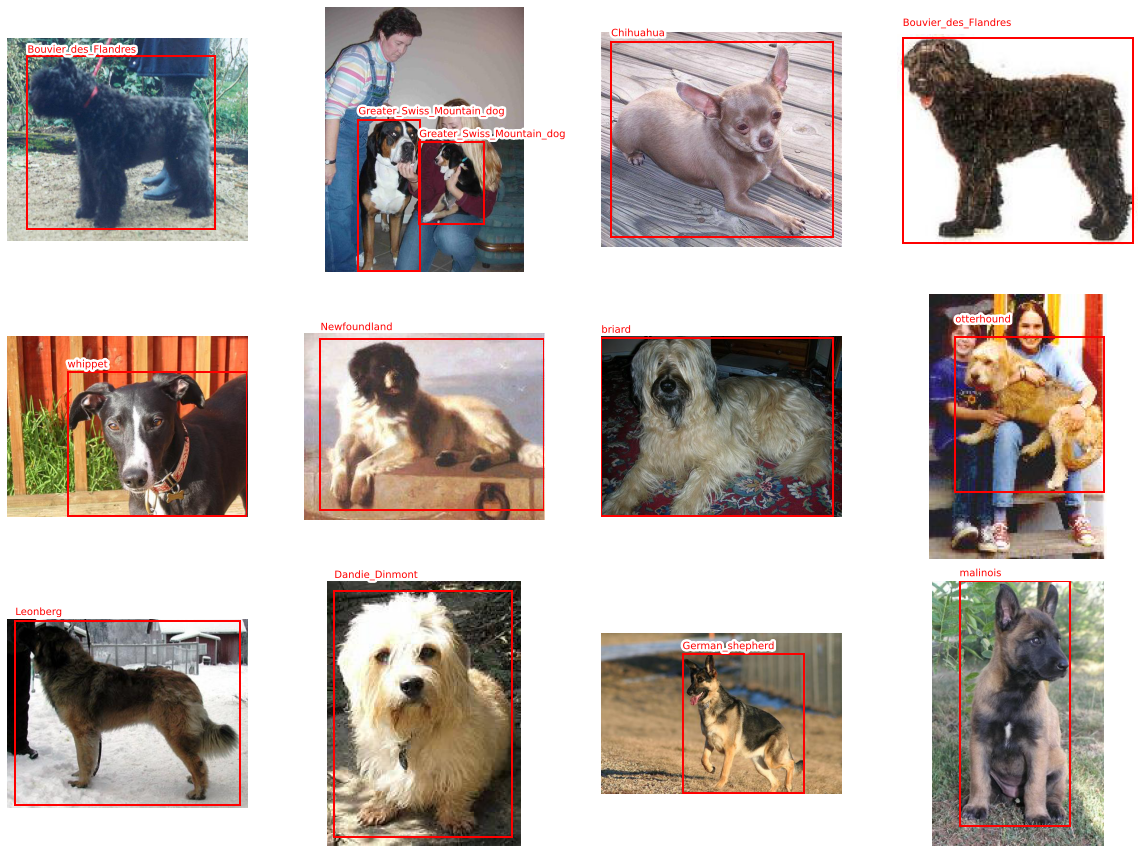

In [23]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(breeds_dogs_train_dataset)-1)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [24]:
import torch
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

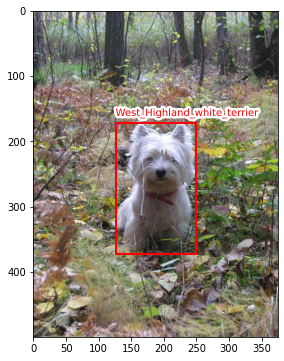

In [34]:
img_np, anns = get_sample(5245)
plot_anns(img_np, anns)
plt.show()

In [27]:
model.eval()
outputs = model([torch.tensor(img_np / 255.).permute(2,0,1).float()])
outputs

[{'boxes': tensor([[ 91.1046,   3.2350, 460.0966, 367.1055],
          [200.2697,   3.4476, 466.9095, 233.1244],
          [291.2805,   9.0977, 463.9613, 185.7543],
          [217.1054, 236.9610, 256.9934, 257.4869]], grad_fn=<StackBackward>),
  'labels': tensor([18, 18, 18, 34]),
  'scores': tensor([0.9980, 0.5046, 0.0672, 0.0546], grad_fn=<IndexBackward>)}]

In [28]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

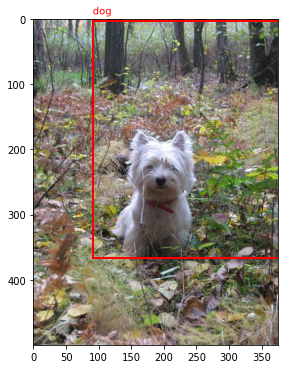

In [33]:
img_np, anns = get_sample(5245)
# nos quedamos con la primera detección
bb = outputs[0]['boxes'][0].long().tolist()
bb = [bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]]
plot_anns(img_np, (outputs[0]['labels'][:1], [bb]), classes=COCO_INSTANCE_CATEGORY_NAMES)
plt.show()

In [35]:
def predict(img, threshold=0.8):
    model.eval()
    outputs = model([torch.tensor(img_np / 255.).permute(2,0,1).float()])
    # nos quedamos con la primera detección
    bb = outputs[0]['boxes'][0].long().tolist()
    bbs = [[bb[0], bb[1], bb[2]-bb[0], bb[3]-bb[1]] for o in outputs for bb, score in zip(o['boxes'], o['scores']) if score > threshold]
    labels = [lab for o in outputs for lab, score in zip(o['labels'], o['scores']) if score > threshold]
    return labels, bbs

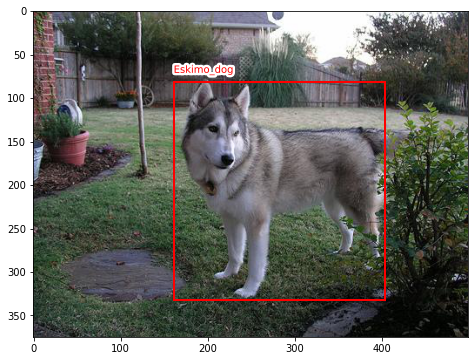

In [36]:
ix = random.randint(0, len(breeds_dogs_train_dataset)-1)
img_np, anns = get_sample(ix)
plot_anns(img_np, anns)
plt.show()

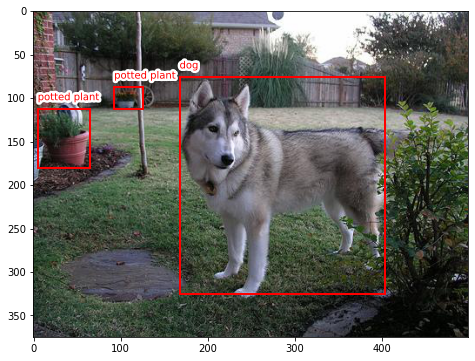

In [37]:
anns = predict(img_np)
plot_anns(img_np, anns, classes=COCO_INSTANCE_CATEGORY_NAMES)
plt.show()